# 빅데이터 분석 프로젝트

>### 가상화폐 거래추세에 따른 그래픽카드 거래추세 변동 확인하기

* 데이터 수집 (크롤링)

* 데이터 전처리 및 가공

* 데이터 저장

* 데이터 시각화

* 결론


# 한글폰트적용

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,018 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and dire

In [ ]:
# 런타임 재시작
import os

os.kill(os.getpid(), 9)

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

#그래픽카드 데이터 수집

##그래픽카드 중고가격 크롤링
>nvidia_gpu

In [72]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen

# 칩셋, 날짜선택 안한 기본 url
baseUrl = urlopen("https://usedking.xyz/gpu/")

# 칩셋 선택 select태그 가져와서 chipsetList 만들기
ext_data = BeautifulSoup(baseUrl, 'html.parser')
selectValue = ext_data.find('select').get_text()

# 줄바꿈 기준으로 스플릿 후 쓸데없는 값 제거
chipsetList = selectValue.split("\n")
del chipsetList[0:2]
del chipsetList[-1]

# 칩셋리스트를 통해 전체 칩셋에 대한 데이터 크롤링
table_list = []
for chip in chipsetList:
  url = "https://usedking.xyz/gpu/?select_gpu={0}&days=all".format(chip)
  tables = pd.read_html(url)

  # 테이블이 존재하는지 확인하고 작업 수행
  if len(tables) > 0:
    table_list.append(tables[0])
  else:
    print("해당 {0}에 대한 거래정보 없음".format(chip))

#gpu_price_df에 table_list 합치기
gpu_price_df = pd.concat(table_list, ignore_index=True)

#csv파일로 gpu_pirce_df저장하기
gpu_price_df.to_csv('/content/gpu_nvidia.csv', encoding='utf-8', index=False)

>radeon_gpu

In [73]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen

# 칩셋, 날짜선택 안한 기본 url
baseUrl = urlopen("https://usedking.xyz/radeon/")
# 칩셋 선택 select태그 가져와서 chipsetList 만들기
ext_data = BeautifulSoup(baseUrl, 'html.parser')
selectValue = ext_data.find('select').get_text()
# 줄바꿈 기준으로 스플릿 후 쓸데없는 값 제거
chipsetList = selectValue.split("\n")
del chipsetList[0:2]
del chipsetList[-1]

table_list = []
for chip in chipsetList:
  url = "https://usedking.xyz/radeon/?select_gpu={0}&days=all".format(chip)
  tables = pd.read_html(url)

  # 테이블이 존재하는지 확인하고 작업 수행
  if len(tables) > 0:
    table_list.append(tables[0])
  else:
    print("해당 {0}에 대한 거래정보 없음".format(chip))

#gpu_price_df에 table_list 합치기
gpu_price_df = pd.concat(table_list, ignore_index=True)

#csv파일로 gpu_pirce_df저장하기
gpu_price_df.to_csv('/content/gpu_radeon.csv', encoding='utf-8', index=False)

#그래픽카드 데이터 전처리 및 저장

##그래픽카드 중고거래 데이터 전처리

In [76]:
import pandas as pd

gpu_nvidia_df = pd.read_csv('/content/gpu_nvidia.csv', encoding = 'utf-8')
gpu_radeon_df = pd.read_csv('/content/gpu_radeon.csv', encoding = 'utf-8')

# 2개 제조사 데이터 연결
gpu_concat_df = pd.concat([gpu_nvidia_df, gpu_radeon_df], ignore_index=True)

# 데이터 확인
print(gpu_concat_df.head())
print(gpu_concat_df.shape)
print(gpu_concat_df.info())

# 컬럼명 재설정
gpu_concat_df.rename(columns = {'No' : '거래번호', 'chipset' : '칩셋',
                                'cost' : '거래가격', 'trade_date' : '거래일'}, inplace = True)

# 인덱스 재설정
gpu_concat_df.reset_index(drop=True, inplace=True)
gpu_concat_df.index.name = '총거래번호'

# 거래제목을 기준으로 중복된 값 제거
gpu_concat_df['subj'].drop_duplicates()

# 결측치 확인
print(gpu_concat_df.isnull().sum(axis=0))

# 필요없는 컬럼 삭제
gpu_concat_df.drop(['subj'], axis = 1, inplace = True)
gpu_concat_df

# 거래일 값 형식변경 및 필요한 형태로 새 열 생성
gpu_concat_df['거래일'] = pd.to_datetime(gpu_concat_df['거래일'])
gpu_concat_df['거래일(월)'] = gpu_concat_df['거래일'].dt.strftime('%Y-%m')
gpu_concat_df['거래일(주)'] = gpu_concat_df['거래일'].dt.to_period('W-Mon').astype(str).str.split('/').str[0].str.replace("-","")

# 전처리 후 데이터 확인 및 저장
gpu_concat_df.to_csv('/content/gpu_concat.csv', encoding='utf-8')
gpu_concat_df

     No  chipset     cost                                               subj  \
0  1152  rtx4090  2600000  [대전]ZOTAC RTX 4090 AMP EXTREME AIRO (조텍 앰프 익스트...   
1  1151  rtx4090  2600000                                 엔비디아 RTX4090 FE팝니다   
2  1150  rtx4090  2400000                            INNO3D iCHILL 4090 팝니다.   
3  1149  rtx4090  2600000                       MSI RTX 4090 슈프림 X 그래픽카드 팝니다   
4  1148  rtx4090  2600000                                     4090 만리 판매 합니다   

   trade_date  
0  2023-11-29  
1  2023-11-29  
2  2023-11-29  
3  2023-11-29  
4  2023-11-29  
(15302, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15302 entries, 0 to 15301
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   No          15302 non-null  int64 
 1   chipset     15302 non-null  object
 2   cost        15302 non-null  int64 
 3   subj        15302 non-null  object
 4   trade_date  15302 non-null  object
dtypes: int64(2), object

,거래번호,칩셋,거래가격,거래일,거래일(월),거래일(주)
총거래번호,,,,,,
0,1152,rtx4090,2600000,2023-11-29,2023-11,20231128
1,1151,rtx4090,2600000,2023-11-29,2023-11,20231128
2,1150,rtx4090,2400000,2023-11-29,2023-11,20231128
3,1149,rtx4090,2600000,2023-11-29,2023-11,20231128
4,1148,rtx4090,2600000,2023-11-29,2023-11,20231128
...,...,...,...,...,...,...
15297,5,vega64,200000,2022-10-21,2022-10,20221018
15298,4,vega64,400000,2022-10-21,2022-10,20221018
15299,3,vega64,270000,2022-10-09,2022-10,20221004


##채굴에 자주사용되는 gpu선별

> 칩셋별 해시레이트, 채산성 데이터 수집
> * 해시레이트? 초당 해시값 계산 횟수의 총합. 즉, 주어진 채굴기가 작동하는 속도

In [77]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# 사이트 url
url = "https://dongdinolife.tistory.com/entry/%EA%B7%B8%EB%9E%98%ED%94%BD%EC%B9%B4%EB%93%9C-%EC%A2%85%EB%A5%98%EB%B3%84%EB%A1%9C-%EC%9D%B4%EB%8D%94%EB%A6%AC%EC%9B%80-%EC%B1%84%EA%B5%B4-%ED%95%B4%EC%8B%9C-%EA%B0%92-%EC%A0%95%EB%A6%AC%ED%95%B4%EB%93%9C%EB%A6%BD%EB%8B%88%EB%8B%A4"

# url로 요청
response = requests.get(url)

# response 코드가 200이면(연결성공) 테이블 데이터 가져오기
if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  table_list = []
  tables = pd.read_html(str(soup))

  for idx, table in enumerate(tables):
    # 테이블 값 확인후 인덱스 행 제외 후 append
    table_list.append(table.iloc[1:])

# 필요없는 테이블 제거
table_list.pop()

# gpu 해시레이트 및 채산성 데이터프레임 생성
gpu_spec_df = pd.concat(table_list, ignore_index=True)

# 컬럼명 재설정
gpu_spec_df.rename(columns = {0 : '칩셋', 1 : '해시레이트', 2 : '채산성'}, inplace = True)

# hashrate, payability 값 수정
gpu_spec_df['해시레이트'] = gpu_spec_df['해시레이트'].str.replace("29 ~31", "30").str.replace("Mh/s", "")
print(gpu_spec_df['해시레이트'].unique())

gpu_spec_df['채산성'] = gpu_spec_df['채산성'].str.replace("약 ","").str.replace("만원", "0000")
print(gpu_spec_df['채산성'].unique())
gpu_spec_df['채산성'] = gpu_spec_df['채산성'].str.replace("만 ","").str.replace("천원", "000")
print(gpu_spec_df['채산성'].unique())


# hashrate, payability 타입 변환
gpu_spec_df['해시레이트'] = gpu_spec_df['해시레이트'].astype(float)
gpu_spec_df['채산성'] = gpu_spec_df['채산성'].astype(int)

# csv파일로 저장
gpu_spec_df.to_csv('/content/gpu_spec.csv', encoding='utf-8', index=False)
gpu_spec_df

['23' '26' '30' '34' '41' '29' '28' '40' '42' '56' '48' '60' '93' '120'
 '55' '43' '63']
['60000' '70000' '8만 5천원' '90000' '120000' '80000' '7만 8천원' '110000'
 '150000' '130000' '180000' '270000' '360000' '200000']
['60000' '70000' '85000' '90000' '120000' '80000' '78000' '110000'
 '150000' '130000' '180000' '270000' '360000' '200000']


,칩셋,해시레이트,채산성
0,GTX 1060 (6GB),23.0,60000
1,GTX 1070,26.0,70000
2,GTX 1070Ti,30.0,85000
3,GTX 1080,34.0,90000
4,GTX 1080Ti,41.0,120000
5,GTX 1660,23.0,60000
6,GTX 1660 Super,29.0,80000
7,GTX 1660 Ti,28.0,78000
8,RTX 2060,30.0,85000
9,RTX 2060 Super,40.0,110000


> 칩셋별 해시레이트, 채산성 확인

<ipython-input-9-5dd80593f22c>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(new_yticklabels)


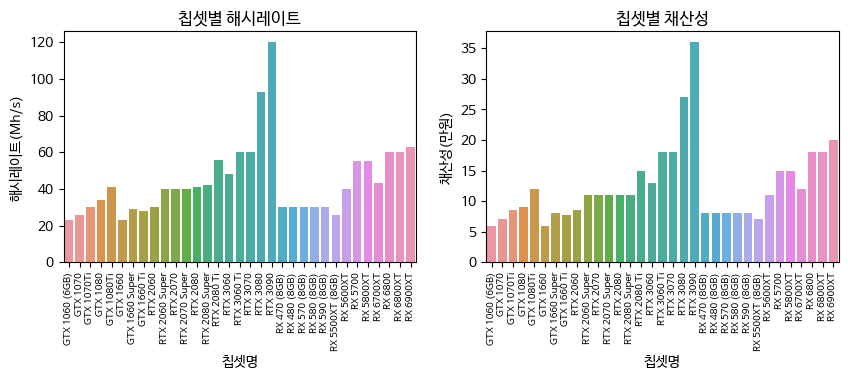

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))

# subplot(2, 2) 생성
ax1=plt.subplot(1, 2, 1)
ax2=plt.subplot(1, 2, 2)

# 1번 그래프, 칩셋별 해시레이트
sns.barplot(data=gpu_spec_df, x='칩셋', y='해시레이트', ax=ax1)
ax1.set_xlabel('칩셋명')
ax1.set_ylabel('해시레이트(Mh/s)')
ax1.set_title('칩셋별 해시레이트')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 7)

# 2번 그래프, 칩셋별 채산성
sns.barplot(data=gpu_spec_df, x='칩셋', y='채산성', ax=ax2)
ax2.set_xlabel('칩셋명')
ax2.set_ylabel('채산성(만원)')
ax2.set_title('칩셋별 채산성')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 7)
# y축 눈금 수정
new_yticklabels = [int(x/10000) for x in ax2.get_yticks()]
ax2.set_yticklabels(new_yticklabels)

plt.show()

> 칩셋별 거래량 확인

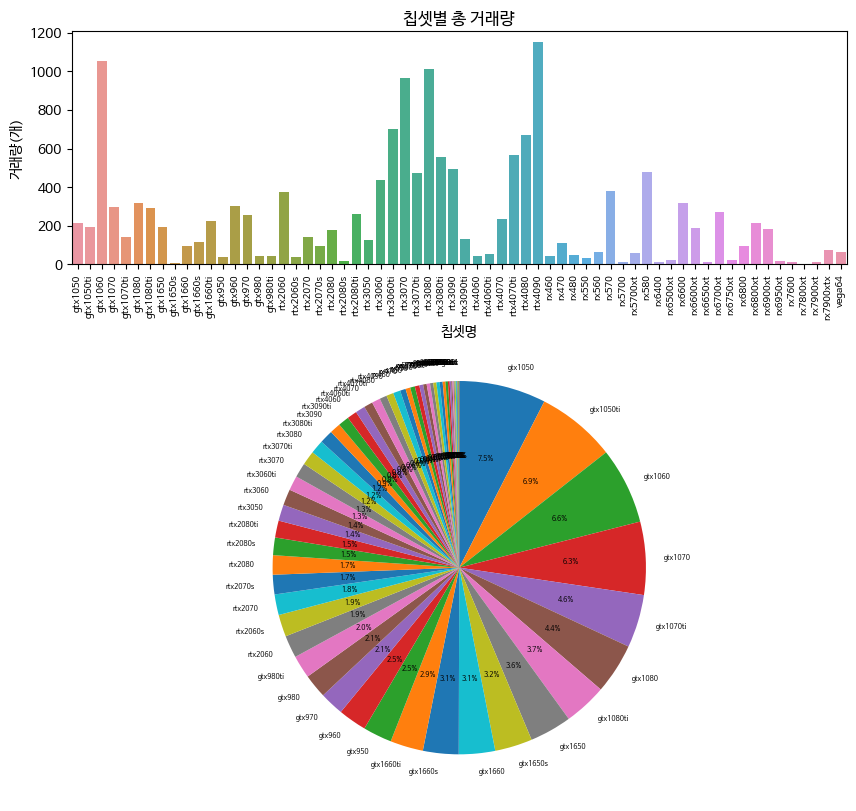

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 칩셋별 거래량 카운트
chipset_count = gpu_concat_df.groupby(['칩셋']).size().reset_index(name='count')

chipset_count_sort = chipset_count.sort_values(by='count', ascending=False)


# 서브플롯 생성 및 사이즈 조절
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 2]})

# 1번 그래프
sns.barplot(data=chipset_count, x='칩셋', y='count', ax=ax1)
ax1.set_xlabel('칩셋명')
ax1.set_ylabel('거래량(개)')
ax1.set_title('칩셋별 총 거래량')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize = 7)

# 2번 그래프
ax2.pie(chipset_count_sort['count'], labels=chipset_count['칩셋'],
        autopct='%.1f%%', startangle=90, counterclock=False, textprops={'size':5})

plt.show()

> 해시레이트, 거래량 순위

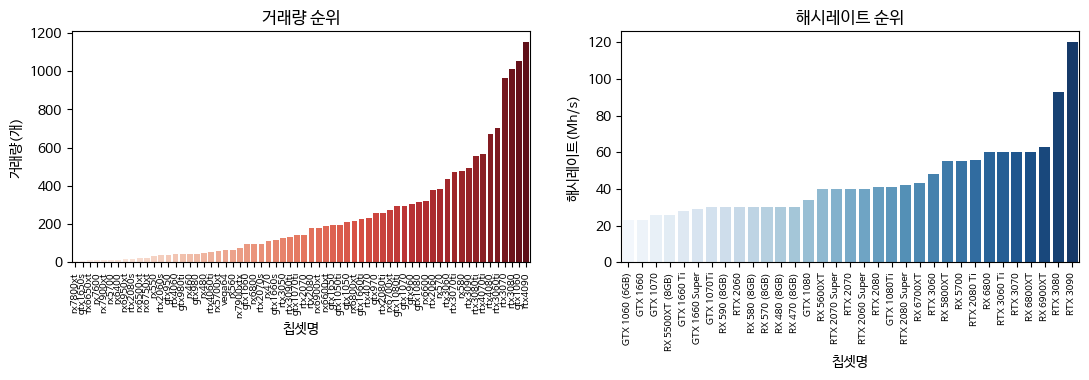

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(13, 3))

# subplot(1, 2) 생성
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# 1번 그래프, 칩셋별 거래량
sorted_df = chipset_count.sort_values(by='count', ascending=True)
sns.barplot(data=sorted_df, x='칩셋', y='count', order=sorted_df['칩셋'], palette = 'Reds', ax=ax1)
ax1.set_xlabel('칩셋명')
ax1.set_ylabel('거래량(개)')
ax1.set_title('거래량 순위')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=7)

# 2번 그래프, 칩셋별 해시레이트
sorted_df = gpu_spec_df.sort_values(by='해시레이트', ascending=True)
sns.barplot(data=sorted_df, x='칩셋', y='해시레이트', order=sorted_df['칩셋'], palette = 'Blues', ax=ax2)
ax2.set_xlabel('칩셋명')
ax2.set_ylabel('해시레이트(Mh/s)')
ax2.set_title('해시레이트 순위')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, fontsize=7)

plt.show()

#그래픽카드 데이터 가공

## 거래량, 해시레이트 등 조건을 고려하여 가상화폐 채굴에 자주 쓰이는 GPU 선별

In [78]:
import pandas as pd

# 제조사별 칩셋으로 그룹화
grouped_chipset = gpu_concat_df.groupby(['칩셋'])

# 그룹화 된 데이터를 concat하기 위한 임시 리스트
temp_list = [grouped_chipset.get_group('rx470'), grouped_chipset.get_group('rx480'),
             grouped_chipset.get_group('rx580'), grouped_chipset.get_group('rx5700'),
             grouped_chipset.get_group('rx5700xt'), grouped_chipset.get_group('rx6800'),
             grouped_chipset.get_group('gtx1060'), grouped_chipset.get_group('gtx1070'),
             grouped_chipset.get_group('gtx1080ti'), grouped_chipset.get_group('gtx1660ti'),
             grouped_chipset.get_group('rtx3060ti'), grouped_chipset.get_group('rtx3070')]

gpu_mostUsed_df = pd.concat(temp_list, ignore_index=True)

gpu_mostUsed_df.to_csv('/content/gpu_mostUsed.csv', encoding='utf-8', index=False)
gpu_mostUsed_df

,거래번호,칩셋,거래가격,거래일,거래일(월),거래일(주)
0,111,rx470,40000,2023-11-07,2023-11,20231107
1,110,rx470,50000,2023-10-26,2023-10,20231024
2,109,rx470,25000,2023-10-06,2023-10,20231003
3,108,rx470,45000,2023-10-01,2023-10,20230926
4,107,rx470,40000,2023-09-19,2023-09,20230919
...,...,...,...,...,...,...
4336,5,rtx3070,340000,2022-12-26,2022-12,20221220
4337,4,rtx3070,450000,2022-12-26,2022-12,20221220
4338,3,rtx3070,455000,2022-12-26,2022-12,20221220
4339,2,rtx3070,420000,2022-12-26,2022-12,20221220


## 선별된 데이터 전처리

In [79]:
# 위에서 데이터를 로드하고 처리한 부분
gpu_mostUsed_df

# 칩셋, 거래일 별 가격 평균
mean_price = gpu_mostUsed_df.groupby(['칩셋', '거래일(월)', '거래일(주)'])['거래가격'].mean()
mean_price = mean_price.round().astype(int)

print(mean_price)

# 가격이 평균보다 기준치 이상일 때 데이터 값 전리
for chipset, month, week in mean_price.index:
    cursor = (gpu_mostUsed_df['칩셋'] == chipset) & (gpu_mostUsed_df['거래일(월)'] == month) & (gpu_mostUsed_df['거래일(주)'] == week)
    over_value = gpu_mostUsed_df.loc[cursor, '거래가격'] > 1.5 * mean_price.loc[(chipset, month, week)]
    gpu_mostUsed_df.loc[cursor & over_value, '거래가격'] = mean_price.loc[(chipset, month, week)] * 0.7

gpu_mostUsed_df.to_csv('/content/gpu_mostUsed.csv', encoding='utf-8', index=False)
gpu_mostUsed_df

칩셋       거래일(월)   거래일(주)  
gtx1060  2022-12  20221220     80269
                  20221227     82207
         2023-01  20221227     86714
                  20230103     73488
                  20230110     75270
                               ...  
rx6800   2023-11  20231031    324500
                  20231107    310000
                  20231114    316667
                  20231121    336667
                  20231128    303000
Name: 거래가격, Length: 618, dtype: int64


,거래번호,칩셋,거래가격,거래일,거래일(월),거래일(주)
0,111,rx470,40000.0,2023-11-07,2023-11,20231107
1,110,rx470,50000.0,2023-10-26,2023-10,20231024
2,109,rx470,25000.0,2023-10-06,2023-10,20231003
3,108,rx470,45000.0,2023-10-01,2023-10,20230926
4,107,rx470,40000.0,2023-09-19,2023-09,20230919
...,...,...,...,...,...,...
4336,5,rtx3070,340000.0,2022-12-26,2022-12,20221220
4337,4,rtx3070,450000.0,2022-12-26,2022-12,20221220
4338,3,rtx3070,455000.0,2022-12-26,2022-12,20221220
4339,2,rtx3070,420000.0,2022-12-26,2022-12,20221220


#그래픽카드 데이터 시각화

## 칩셋별 가격 그래프

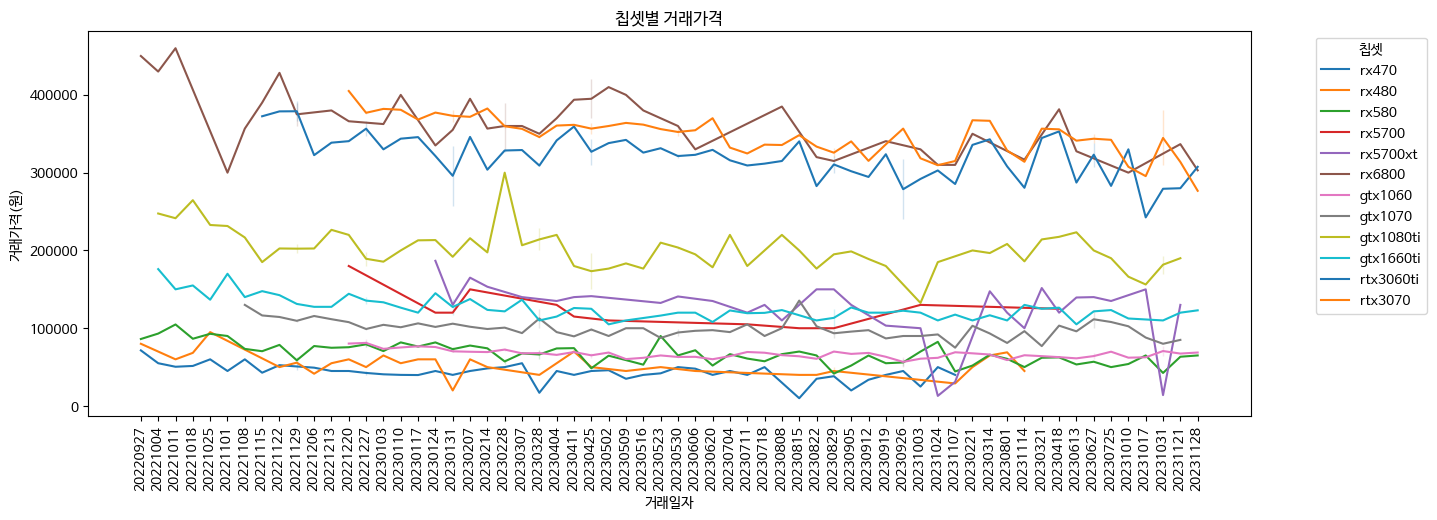

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 칩셋, 거래일 별 거래가격 그래프를 위한 데이터 뽑아내기
mean_price = gpu_mostUsed_df.groupby(['칩셋', '거래일(월)', '거래일(주)'])['거래가격'].mean()
mean_price = mean_price.round().astype(int)

graph_data = pd.DataFrame(index=mean_price.index)
graph_data['거래가격'] = mean_price.values

#print(graph_data)

# 그래프 속성
plt.figure(figsize=(15, 5))
plt.xlabel('거래일자')
plt.ylabel('거래가격(원)')
plt.title('칩셋별 거래가격')

# 칩셋명 리스트
chipset_list = gpu_mostUsed_df['칩셋'].unique()

#print(chipset_list)
for chipset in chipset_list:
    fi = sns.lineplot(data=graph_data.loc[chipset], x='거래일(주)', y='거래가격', label=chipset)

# 그래프 표시
plt.xticks(rotation=90)
plt.legend(title='칩셋', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 칩셋별 거래량 그래프

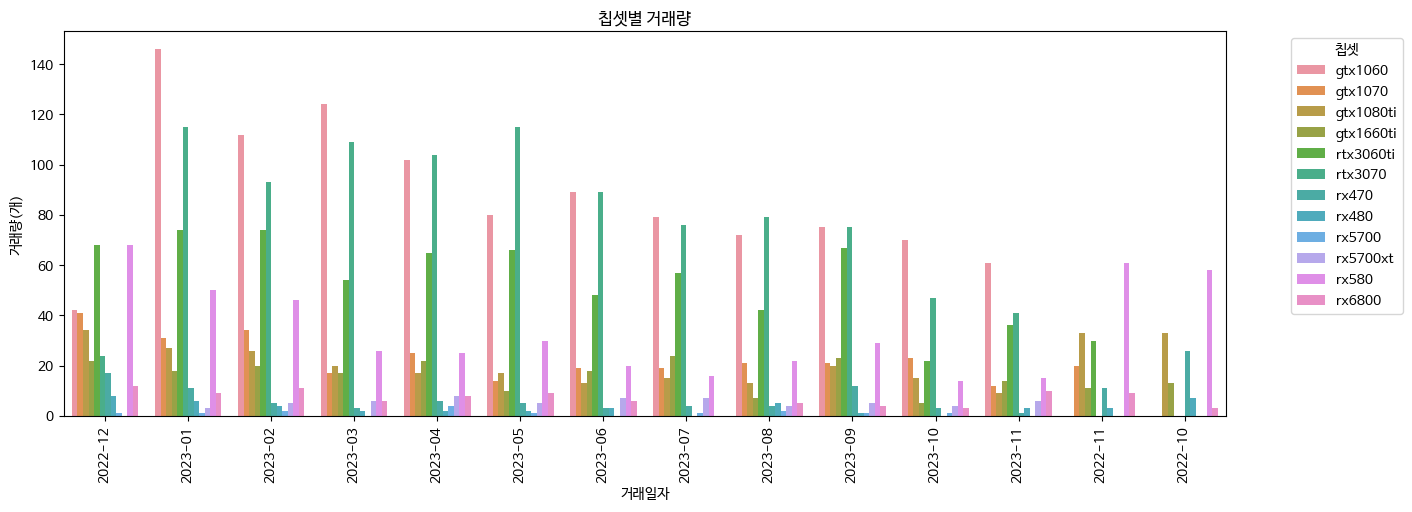

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 칩셋, 거래일자로 묶은 거래량 데이터
count_data = gpu_mostUsed_df.groupby(['칩셋', '거래일(월)']).size().reset_index(name='count')

# 그래프 속성
plt.figure(figsize=(15, 5))

plt.title('칩셋별 거래량')

# 그래프 그리기 (누적 막대 그래프)
sns.barplot(data=count_data, x='거래일(월)', y='count', hue='칩셋', dodge=True)

# 그래프 표시
plt.xlabel('거래일자')
plt.ylabel('거래량(개)')
plt.xticks(rotation=90)
plt.legend(title='칩셋', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

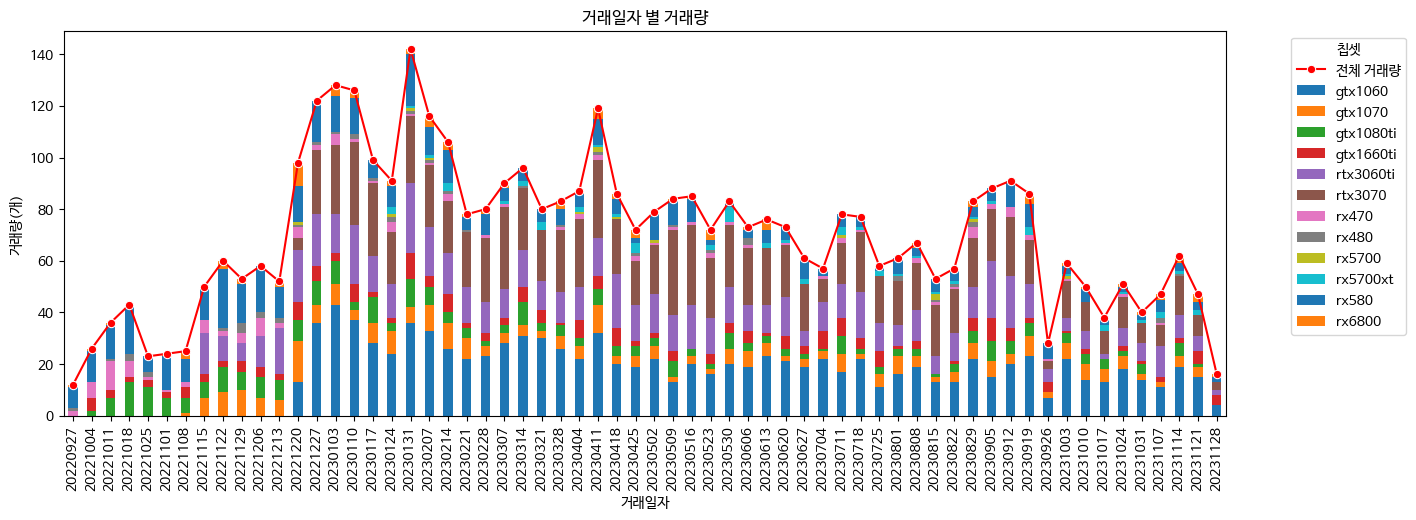

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 칩셋, 거래일자로 묶은 거래량 데이터
count_data = gpu_mostUsed_df.groupby(['거래일(주)', '칩셋']).size().unstack().reset_index()

# 누적 막대 그래프 그리기
count_data.set_index('거래일(주)').plot(kind='bar', stacked=True, figsize=(15,5))

# 누적 꺾은선 그래프
sns.lineplot(data=gpu_mostUsed_df.groupby('거래일(주)').size().reset_index(name='total_count'),
             x='거래일(주)', y='total_count', color='red', marker='o', label='전체 거래량')

# 그래프 표시
plt.title('거래일자 별 거래량')
plt.xlabel('거래일자')
plt.ylabel('거래량(개)')
plt.xticks(rotation=90)
plt.legend(title='칩셋', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#가상화폐 데이터 수집

## 가상화폐 데이터 수집 FinanceDatareader 라이브러리 사용

In [21]:
!pip install finance-datareader

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

df_btc = fdr.DataReader('BTC/KRW', '2022-09-27')
df_eth = fdr.DataReader('ETH/KRW', '2022-09-27')
df_xrp = fdr.DataReader('XRP/KRW', '2022-09-27')

# 인덱스 초기화
df_btc.reset_index(inplace=True)
df_eth.reset_index(inplace=True)
df_xrp.reset_index(inplace=True)

print(df_btc.head())
print(df_eth.head())
print(df_xrp.head())

        Date        Open        High         Low       Close          Volume
0 2022-09-27  27502024.0  28915100.0  27023216.0  27263106.0  83558015760670
1 2022-09-28  27254652.0  28014546.0  26697668.0  27639942.0  75508760441078
2 2022-09-29  27641450.0  28131658.0  27126500.0  27999444.0  58705045893071
3 2022-09-30  27999990.0  28872454.0  27684356.0  27986246.0  63334471548874
4 2022-10-01  27985260.0  28042942.0  27697182.0  27813858.0  26960439738207
        Date         Open         High          Low        Close  \
0 2022-09-27  1910559.625  1985955.000  1870045.500  1897560.125   
1 2022-09-28  1896723.625  1923710.375  1826958.000  1902840.875   
2 2022-09-29  1903045.125  1930045.250  1853686.000  1910664.000   
3 2022-09-30  1910655.625  1965549.125  1896980.875  1912594.625   
4 2022-10-01  1912904.500  1919130.250  1881088.000  1889069.625   

           Volume  
0  25494196443747  
1  27025669163794  
2  19736625929491  
3  20523421657022  
4   8969696611660  
        D

# 가상화폐 데이터 시각화

## 코인별 캔들스틱 그래프

> BTC(비트코인)

In [49]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Candlestick(x=df_btc['Date'],
                                 open=df_btc['Open'],
                                 high=df_btc['High'],
                                 low=df_btc['Low'],
                                 close=df_btc['Close']))

# 레이아웃 설정
fig.update_layout(width=1000, height=500, xaxis_rangeslider_visible=True,
                  title=dict(text='비트코인(BTC)', x=0.5, y=0.9, xanchor='center', yanchor='top'))

fig.show()

>ETH(이더리움)

In [50]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Candlestick(x=df_eth['Date'],
                                 open=df_eth['Open'],
                                 high=df_eth['High'],
                                 low=df_eth['Low'],
                                 close=df_eth['Close']))

# 레이아웃 설정
fig.update_layout(width=1000, height=500, xaxis_rangeslider_visible=True,
                  title=dict(text='이더리움(ETH)', x=0.5, y=0.9, xanchor='center', yanchor='top'))

fig.show()

>XRP(리플)

In [51]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Candlestick(x=df_xrp['Date'],
                                 open=df_xrp['Open'],
                                 high=df_xrp['High'],
                                 low=df_xrp['Low'],
                                 close=df_xrp['Close']))

# 레이아웃 설정
fig.update_layout(width=1000, height=500, xaxis_rangeslider_visible=True,
                  title=dict(text='리플(XRP)', x=0.5, y=0.9, xanchor='center', yanchor='top'))

fig.show()

#가상화폐 데이터 전처리 및 저장

## 가상화폐 거래가격 데이터 전처리

In [80]:
# 데이터 연결
df_btc['종류'] = "BTC"
df_eth['종류'] = "ETH"
df_xrp['종류'] = "XRP"

df_crypto = pd.concat([df_btc, df_eth, df_xrp])

# 연결된 데이터프레임 확인
print(df_crypto.head())
print(df_crypto.info())
print(df_crypto.describe())

# 인덱스 초기화
df_crypto.reset_index(inplace=True)

# 필요없는 행 삭제
df_crypto.drop(['index', 'Open', 'High', 'Low'], axis=1, inplace=True)

# 컬럼명 재설정
df_crypto.rename(columns={'Date' : '거래일', 'Close' : '가격(원)', 'Volume' : '거래량(원)'}, inplace=True)

# 날짜데이터 필요한 형태로 수정
df_crypto['거래일(주)'] = df_crypto['거래일'].dt.to_period('W-Mon').astype(str).str.split('/').str[0].str.replace("-","")

# 컬럼순서 변경
df_crypto = df_crypto[['종류', '가격(원)', '거래량(원)', '거래일', '거래일(주)']]

# 데이터프레임 저장
df_crypto.to_csv('/content/crypto_concat.csv', encoding = 'cp949', index=False)
df_crypto

        Date        Open        High         Low       Close          Volume  \
0 2022-09-27  27502024.0  28915100.0  27023216.0  27263106.0  83558015760670   
1 2022-09-28  27254652.0  28014546.0  26697668.0  27639942.0  75508760441078   
2 2022-09-29  27641450.0  28131658.0  27126500.0  27999444.0  58705045893071   
3 2022-09-30  27999990.0  28872454.0  27684356.0  27986246.0  63334471548874   
4 2022-10-01  27985260.0  28042942.0  27697182.0  27813858.0  26960439738207   

    종류  
0  BTC  
1  BTC  
2  BTC  
3  BTC  
4  BTC  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 0 to 429
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1290 non-null   datetime64[ns]
 1   Open    1290 non-null   float64       
 2   High    1290 non-null   float64       
 3   Low     1290 non-null   float64       
 4   Close   1290 non-null   float64       
 5   Volume  1290 non-null   int64         
 6   종류 

,종류,가격(원),거래량(원),거래일,거래일(주)
0,BTC,2.726311e+07,83558015760670,2022-09-27,20220927
1,BTC,2.763994e+07,75508760441078,2022-09-28,20220927
2,BTC,2.799944e+07,58705045893071,2022-09-29,20220927
3,BTC,2.798625e+07,63334471548874,2022-09-30,20220927
4,BTC,2.781386e+07,26960439738207,2022-10-01,20220927
...,...,...,...,...,...
1285,XRP,8.129715e+02,788276449215,2023-11-26,20231121
1286,XRP,8.053531e+02,1470374870118,2023-11-27,20231121
1287,XRP,7.844418e+02,1570178644155,2023-11-28,20231128
1288,XRP,7.875671e+02,1390850738624,2023-11-29,20231128


#가상화폐 데이터 시각화

## 코인별 가격 그래프

In [182]:
# 주간단위로 거래가격 평균 값 만들기
mean_price = df_crypto.groupby(['종류', '거래일(주)'])['가격(원)'].mean()
mean_price = mean_price.round().astype(int)

print(mean_price)

# 주간당 평균가격으로 묶은 데이터프레임 만들기
graph_data = pd.DataFrame(index=mean_price.index)
graph_data['가격(원)'] = mean_price.values

print(graph_data)

종류   거래일(주)  
BTC  20220927    27751664
     20221004    27988085
     20221011    27604190
     20221018    27579774
     20221025    29188698
                   ...   
XRP  20231031         814
     20231107         889
     20231114         821
     20231121         798
     20231128         786
Name: 가격(원), Length: 186, dtype: int64
                 가격(원)
종류  거래일(주)            
BTC 20220927  27751664
    20221004  27988085
    20221011  27604190
    20221018  27579774
    20221025  29188698
...                ...
XRP 20231031       814
    20231107       889
    20231114       821
    20231121       798
    20231128       786

[186 rows x 1 columns]


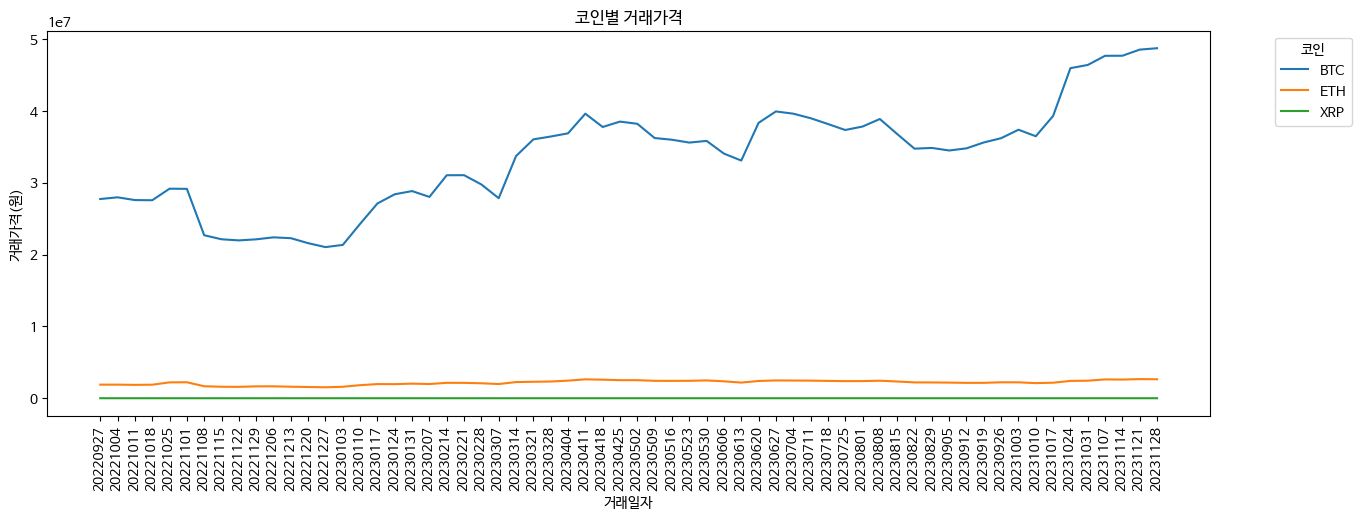

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 속성
plt.figure(figsize=(15, 5))
plt.xlabel('거래일자')
plt.ylabel('거래가격(원)')
plt.title('코인별 거래가격')

# 코인명 리스트
coin_list = df_crypto['종류'].unique()

for coin in coin_list:
  fi = sns.lineplot(data=graph_data.loc[coin], x='거래일(주)', y='가격(원)', label=coin)

# 그래프 표시
plt.xticks(rotation=90)
plt.legend(title='코인', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

> BTC의 값이 상대적으로 너무 커 ETH, XRP의 경향성이 잘 보이지 않음
> * 거래가격의 상대적 비율로 계산해 경향성 표시

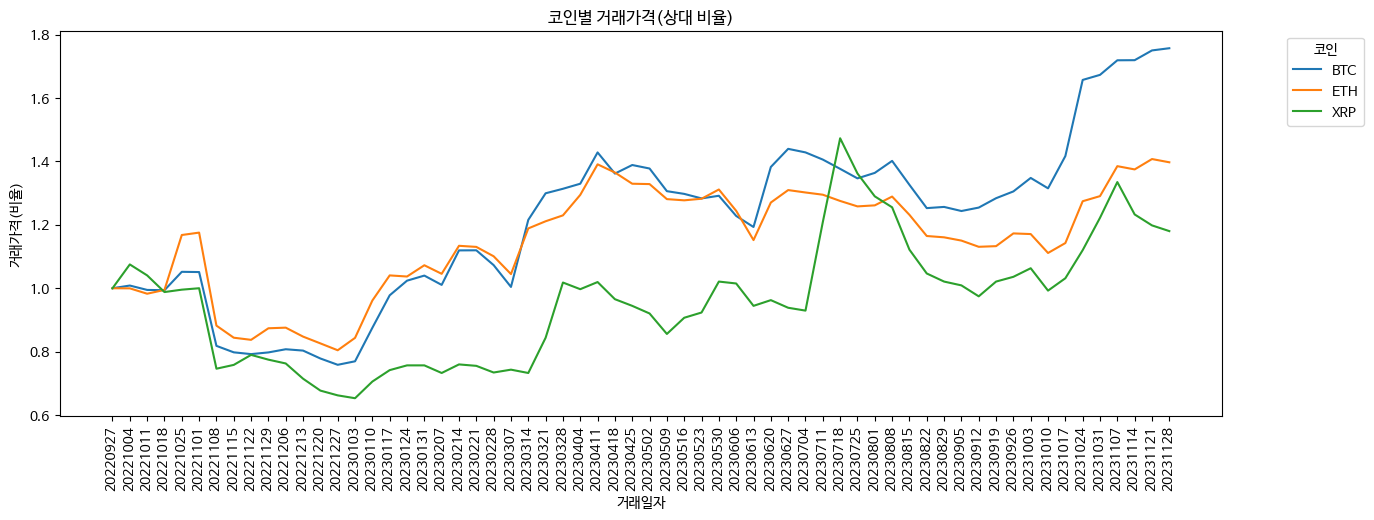

In [184]:
# 첫 번째 주의 가격을 기준으로 상대적 가격 비율구하기
graph_data['상대비율'] = graph_data.groupby('종류')['가격(원)'].transform(lambda x: x / x.iloc[0])

# 그래프 속성
plt.figure(figsize=(15, 5))
plt.xlabel('거래일자')
plt.ylabel('거래가격(비율)')
plt.title('코인별 거래가격(상대 비율)')

for coin in coin_list:
  fi = sns.lineplot(data=graph_data.loc[coin], x='거래일(주)', y='상대비율', label=coin)

# 그래프 표시
plt.xticks(rotation=90)
plt.legend(title='코인', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##코인별 거래량 그래프

In [185]:
# 주간단위로 거래량 평균 값 만들기
mean_price = df_crypto.groupby(['종류', '거래일(주)'])['거래량(원)'].mean()
mean_price = mean_price.round().astype(int)

print(mean_price)

# 주간당 평균거래량으로 묶은 데이터프레임 만들기
graph_data = pd.DataFrame(index=mean_price.index)
graph_data['거래량(원)'] = mean_price.values

print(graph_data)

종류   거래일(주)  
BTC  20220927    54525076035882
     20221004    39276361068736
     20221011    40569833069456
     20221018    36498403710661
     20221025    64539684834339
                      ...      
XRP  20231031     2187074245769
     20231107     2982336259549
     20231114     2207336445310
     20231121     1550114892781
     20231128     1438535183230
Name: 거래량(원), Length: 186, dtype: int64
                      거래량(원)
종류  거래일(주)                  
BTC 20220927  54525076035882
    20221004  39276361068736
    20221011  40569833069456
    20221018  36498403710661
    20221025  64539684834339
...                      ...
XRP 20231031   2187074245769
    20231107   2982336259549
    20231114   2207336445310
    20231121   1550114892781
    20231128   1438535183230

[186 rows x 1 columns]


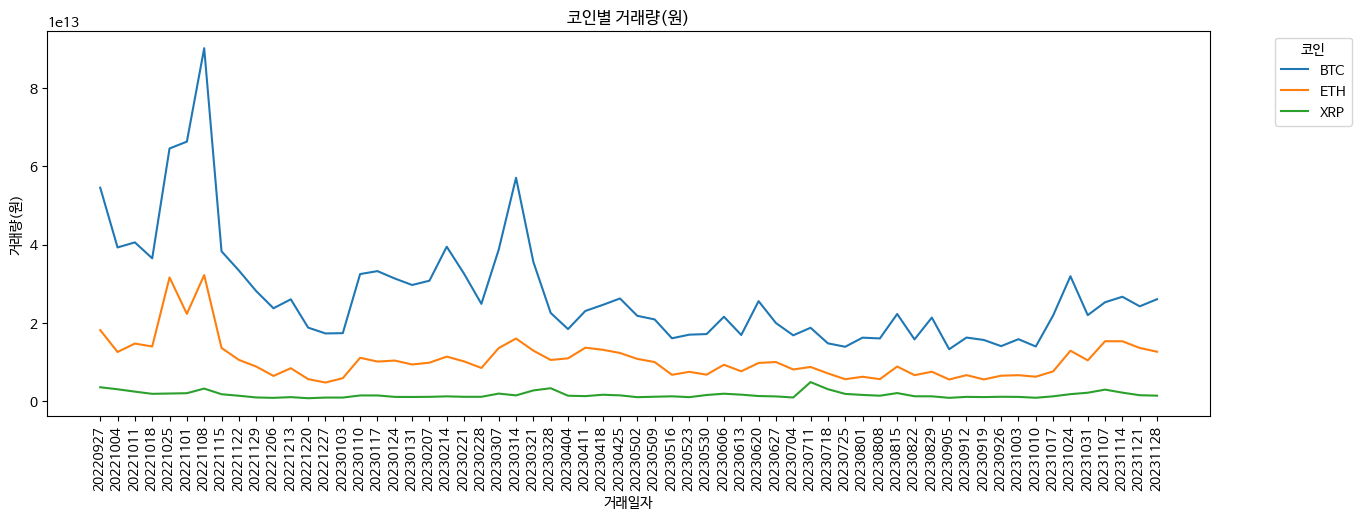

In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 속성
plt.figure(figsize=(15, 5))
plt.xlabel('거래일자')
plt.ylabel('거래량(원)')
plt.title('코인별 거래량(원)')

# 코인명 리스트
coin_list = df_crypto['종류'].unique()

for coin in coin_list:
  fi = sns.lineplot(data=graph_data.loc[coin], x='거래일(주)', y='거래량(원)', label=coin)

# 그래프 표시
plt.xticks(rotation=90)
plt.legend(title='코인', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 데이터 분석

## 그래픽카드 데이터, 가상화폐 데이터 통합 분석

> GPU, 가상화폐의 가격, 거래량 상관관계

In [170]:
import pandas as pd

# 데이터 불러오기
gpu_price = pd.read_csv('/content/gpu_mostUsed.csv', encoding='utf-8')
gpu_spec = pd.read_csv('/content/gpu_spec.csv', encoding='utf-8')
crypto_price = pd.read_csv('/content/crypto_concat.csv', encoding='cp949')

print(gpu_price.head())
print(gpu_spec.head())
print(crypto_price.head())

   거래번호     칩셋     거래가격         거래일   거래일(월)    거래일(주)
0   111  rx470  40000.0  2023-11-07  2023-11  20231107
1   110  rx470  50000.0  2023-10-26  2023-10  20231024
2   109  rx470  25000.0  2023-10-06  2023-10  20231003
3   108  rx470  45000.0  2023-10-01  2023-10  20230926
4   107  rx470  40000.0  2023-09-19  2023-09  20230919
               칩셋  해시레이트     채산성
0  GTX 1060 (6GB)   23.0   60000
1        GTX 1070   26.0   70000
2      GTX 1070Ti   30.0   85000
3        GTX 1080   34.0   90000
4      GTX 1080Ti   41.0  120000
    종류       가격(원)          거래량(원)         거래일    거래일(주)
0  BTC  27263106.0  83558015760670  2022-09-27  20220927
1  BTC  27639942.0  75508760441078  2022-09-28  20220927
2  BTC  27999444.0  58705045893071  2022-09-29  20220927
3  BTC  27986246.0  63334471548874  2022-09-30  20220927
4  BTC  27813858.0  26960439738207  2022-10-01  20220927


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



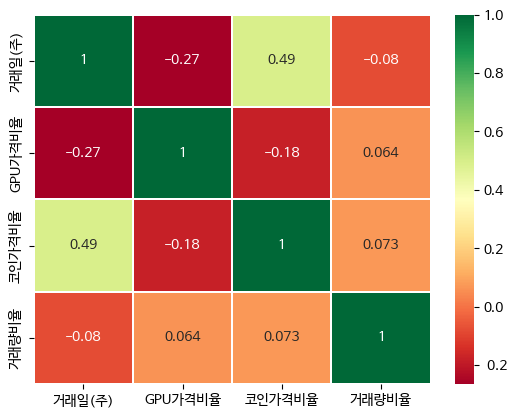

In [179]:
import pandas as pd
import seaborn as sns

# GPU가격, 가상화폐 가격, 거래량 상대비율로 나타내기
gpu_price['가격비율'] = gpu_price.groupby('칩셋')['거래가격'].transform(lambda x: x / x.iloc[0])
crypto_price['가격비율'] = crypto_price.groupby('종류')['가격(원)'].transform(lambda x: x / x.iloc[0])
crypto_price['거래량비율'] = crypto_price.groupby('종류')['거래량(원)'].transform(lambda x: x / x.iloc[0])

# 필요한 열 뽑아내 통합 데이터 프레임 만들기
gpu_price_subset = gpu_price[['거래일(주)', '가격비율']]
crypto_price_subset = crypto_price[['거래일(주)', '가격비율', '거래량비율']]

# 두 데이터프레임을 '거래일(주)' 열을 기준으로 합치기
gpu_crypto_df = pd.merge(gpu_price_subset, crypto_price_subset, how='inner', on='거래일(주)')
gpu_crypto_df.rename(columns={'가격비율_x':'GPU가격비율', '가격비율_y':'코인가격비율'}, inplace=True)
gpu_crypto_df

# 상관 계수 계산
gpu_crypto_df.corr()

sns.heatmap(gpu_crypto_df.corr(),linewidths=0.1, cmap='RdYlGn', linecolor='white', annot=True)

plt.show()

> GPU, 가상화폐 가격 관계

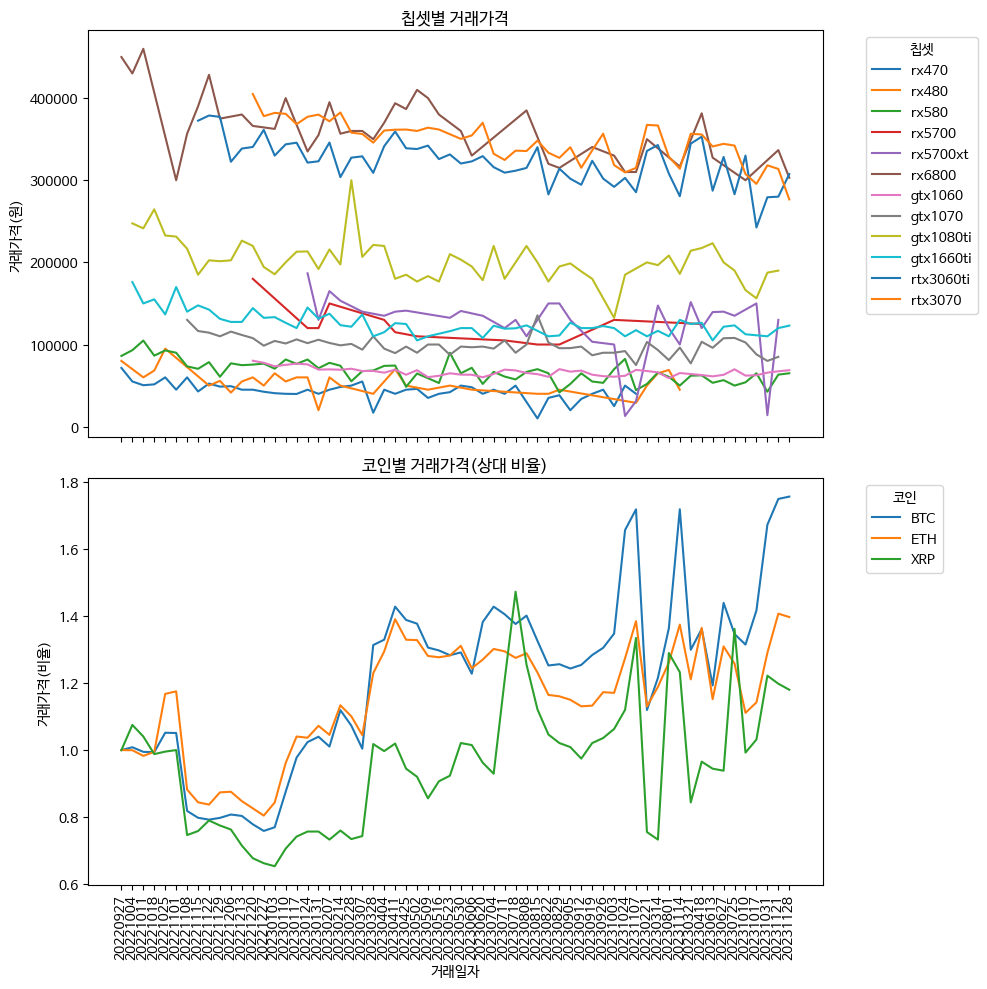

In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 서브플롯 생성
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# 1번 그래프, 칩셋별 거래가격
mean_price_gpu = gpu_mostUsed_df.groupby(['칩셋', '거래일(주)'])['거래가격'].mean()
mean_price_gpu = mean_price_gpu.round().astype(int)

graph_data_gpu = pd.DataFrame(index=mean_price_gpu.index)
graph_data_gpu['거래가격'] = mean_price_gpu.values

for chipset in chipset_list:
    sns.lineplot(data=graph_data_gpu.loc[chipset], x='거래일(주)', y='거래가격', label=chipset, ax=axes[0])

axes[0].set_ylabel('거래가격(원)')
axes[0].set_title('칩셋별 거래가격')
axes[0].legend(title='칩셋', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=90)

# 2번 그래프, 코인별 거래가격
mean_price_crypto = df_crypto.groupby(['종류', '거래일(주)'])['가격(원)'].mean()
mean_price_crypto = mean_price_crypto.round().astype(int)

graph_data_crypto = pd.DataFrame(index=mean_price_crypto.index)
graph_data_crypto['가격(원)'] = mean_price_crypto.values

graph_data_crypto['상대비율'] = graph_data_crypto.groupby('종류')['가격(원)'].transform(lambda x: x / x.iloc[0])

for coin in coin_list:
    sns.lineplot(data=graph_data_crypto.loc[coin], x='거래일(주)', y='상대비율', label=coin, ax=axes[1])

axes[1].set_xlabel('거래일자')
axes[1].set_ylabel('거래가격(비율)')
axes[1].set_title('코인별 거래가격(상대 비율)')
axes[1].legend(title='코인', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

> GPU, 가상화폐 거래량 관계

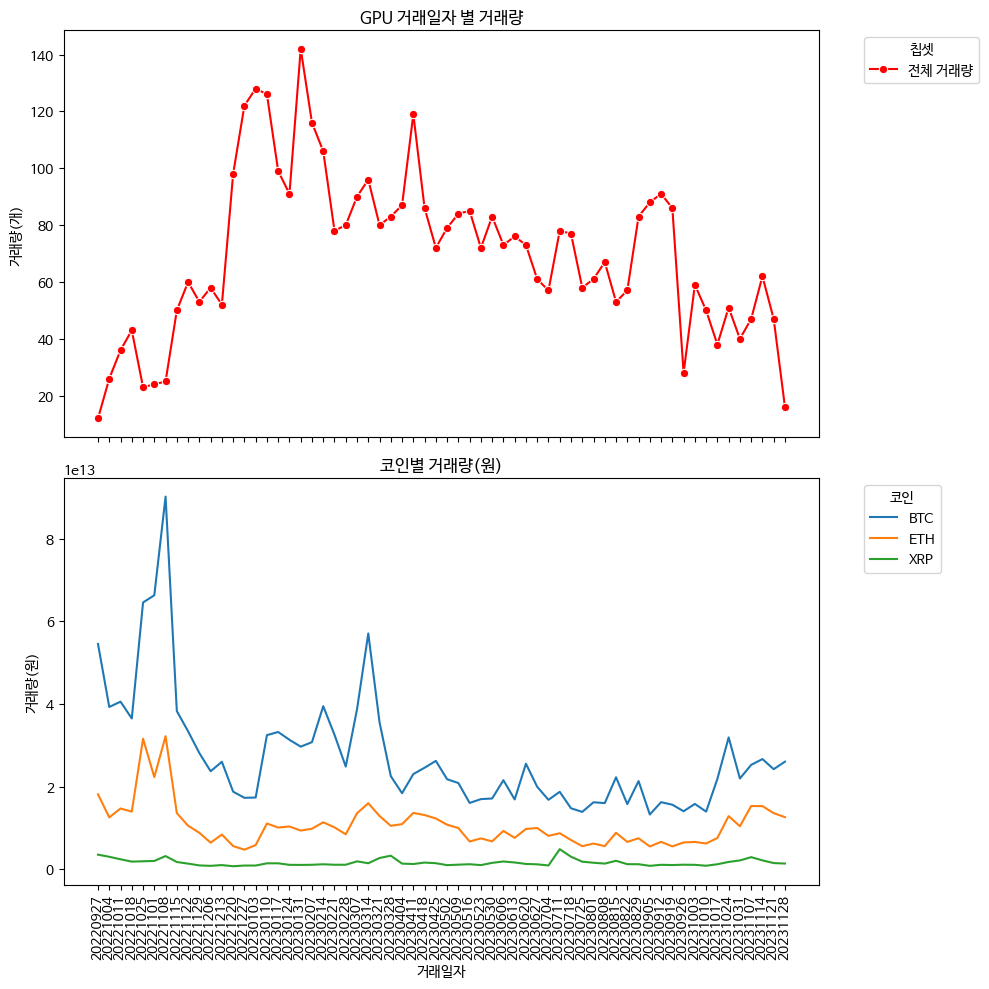

In [207]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 서브플롯 생성
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# 1번 그래프, 칩셋별 거래가격
count_data = gpu_mostUsed_df.groupby(['거래일(주)', '칩셋']).size().unstack().reset_index()

# 누적 꺾은선 그래프
sns.lineplot(data=gpu_mostUsed_df.groupby('거래일(주)').size().reset_index(name='total_count'),
             x='거래일(주)', y='total_count', color='red', marker='o', label='전체 거래량', ax=axes[0])

# 그래프 속성
axes[0].set_ylabel('거래량(개)')
axes[0].set_title('GPU 거래일자 별 거래량')
axes[0].legend(title='칩셋', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=90)

# 2번 그래프, 코인별 거래가격
mean_price = df_crypto.groupby(['종류', '거래일(주)'])['거래량(원)'].mean()
mean_price = mean_price.round().astype(int)

graph_data = pd.DataFrame(index=mean_price.index)
graph_data['거래량(원)'] = mean_price.values

# 그래프 속성
for coin in coin_list:
    fi = sns.lineplot(data=graph_data.loc[coin], x='거래일(주)', y='거래량(원)', label=coin, ax=axes[1])

axes[1].set_xlabel('거래일자')
axes[1].set_ylabel('거래량(원)')
axes[1].set_title('코인별 거래량(원)')
axes[1].legend(title='코인', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

##결론

데이터 분석 주제를 선정할 때, 2018년 쯤 GPU를 구매하면서 가격이 급등한 이유를 찾아보다가 가상화폐와의 관련성을 알게된 적이 있어 선정하게 됐다.<br><br>
직접 데이터를 수집하고 분석하기 전 예측한 결과는 가상화폐의 거래가격이 오를 수록, 가상화폐 마이닝에 사용되는 GPU이 가격 또한 오를 것이라 생각했다.<br>
실제로 분석해본 결과 가상화폐의 거래가격이 GPU의 중고거래 가격에는 큰 영향을 미치지 못하는 것 같다.<br>
하지만 거래량으로 확인해보면 가상화폐의 가격이 올랐을 때 GPU 중고거래량이 증가했으며,<br>
가상화폐의 거래량이 증가한 뒤 몇주간 GPU이 중고거래량도 늘어난 것을 확인할 수 있다.<br><br>
이대로의 추세가 진행된다면, 가상화폐 거래가격과 GPU의 거래가격은 상관성이 계속해 낮아질 것으로 생각된다.
<br><br>
현재의 경우 2018년에 비해 가상화폐에 대한 관심도도 현저히 저하되고, GPU 또한 제조사 측에서 해시레이트를 조정하는 등의 이유 때문에 예측한 결과보다 아쉬운 결과를 얻은 것 같다.


